
<img src="https://raw.githubusercontent.com/scalabrinig/cdProjetoAplicadoIV/d093146488f56dfcf0ef286bcee8efe0e71b9c76/figuras/mackenzie_logo.jpg" width="25%" align="right"/>

# **PROJETO APLICADO IV - Ciência de Dados EaD - 2025/02**

# **Entrega 3**

---
# **Predição da Taxa de Desemprego no Brasil: Séries Temporais com Dados do CAGED, PNAD e SELIC**
---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fpaterni10/projeto-aplicado-iv-desemprego-br/blob/main/notebooks/entrega3/cd_projeto_aplicado_IV_entrega_3.ipynb)

> _Observação:_ se o arquivo for movido de pasta ou renomeado no GitHub, atualize o link do botão acima para refletir o novo caminho.


In [1]:

#@title **Identificação do Grupo e Opção do Projeto**
#@markdown Integrantes do Grupo, nome completo em ordem alfabética (*informe: \, \*)
Aluno1 = 'Aline Correa de Araújo, 10414773' #@param {type:"string"}
Aluno2 = 'Franciele Paterni, 10414598' #@param {type:"string"}
Aluno3 = 'Giovanna Sobral da Silva, 10424600' #@param {type:"string"}
Aluno4 = 'Guilherme Soares Frota, 10416060' #@param {type:"string"}



# **Introdução**

O cenário econômico brasileiro é marcado por oscilações relevantes no mercado de trabalho e na taxa básica de juros (SELIC), fatores diretamente relacionados ao nível de emprego e à renda da população. Compreender esses movimentos é fundamental para a formulação de políticas públicas e para a tomada de decisão em setores estratégicos. A análise de séries temporais aplicadas ao emprego formal e ao comportamento da taxa de desocupação se torna, assim, um instrumento de previsão e planejamento, permitindo antecipar tendências e identificar padrões estruturais na economia brasileira (IBGE, 2025; BACEN, 2025).

O Brasil apresenta histórico de flutuações significativas na geração de empregos formais, influenciadas por fatores macroeconômicos, políticas governamentais e ciclos econômicos. Ao mesmo tempo, a taxa SELIC impacta diretamente a dinâmica do crédito, do consumo e do investimento, refletindo-se na variação do nível de emprego. Dessa forma, existe uma motivação clara em utilizar dados oficiais e atualizados para entender a relação entre esses elementos.

A justificativa central deste trabalho é que a previsão da taxa de desemprego, com base em indicadores fundamentais como o CAGED e a SELIC, oferece valor social e econômico. Tal análise apoia o ODS 8 – Trabalho Decente e Crescimento Econômico, ao fornecer insumos para políticas públicas voltadas à melhoria das condições do mercado de trabalho, além de gerar conhecimento relevante para gestores e pesquisadores.

**Objetivos específicos**: (i) tratar e padronizar as bases (CAGED, PNAD, SELIC); (ii) explorar a série, verificando estacionariedade, sazonalidade e ciclos; (iii) construir e avaliar modelos de previsão (SARIMAX e ML); (iv) comparar acurácia e robustez; e (v) apresentar previsões e insights que apoiem decisões.



# **Referencial Teórico**

Modelos clássicos de séries temporais (ARIMA/SARIMA) são amplamente empregados quando há dependência temporal, tendência e sazonalidade. O SARIMAX, por sua vez, permite incluir variáveis exógenas (e.g., indicadores do CAGED e a SELIC), ampliando a capacidade explicativa. Em termos práticos, a estacionariedade é requisito importante: séries com forte tendência/sazonalidade tendem a exigir diferenciação (ENDERS, 2015; BEIRÃO; GONÇALVES; NETO, 2021).

Além dos métodos estatísticos, abordagens com _machine learning_ (por exemplo, _gradient boosting_) vêm sendo exploradas por sua flexibilidade em capturar relações não lineares. A estratégia adotada neste projeto combina a interpretabilidade do SARIMAX com a capacidade preditiva do LGBM Regressor.



# **Pipeline da Solução**

1. **Coleta e organização** das fontes oficiais (PNAD 4099/IBGE; CAGED/MTE; SELIC/BACEN) e consolidação trimestral (2012–2025).  
2. **Pré-processamento**: tratamento de ausências/outliers, agregações, _joins_ e padronização temporal.  
3. **Análise temporal**: decomposição (tendência, sazonalidade, ruído), testes ADF, ACF e PACF.  
4. **Engenharia de atributos**: médias móveis (rolling), lags, transformações (asinh), dummies sazonais/estruturais.  
5. **Modelagem**: SARIMAX (exógenas do CAGED) e LGBM Regressor (lags e exógenas).  
6. **Validação**: _holdout_ temporal (últimos 4 trimestres), métricas (MAE, RMSE, MAPE) e diagnóstico de resíduos.  
7. **Produto analítico**: gráficos, tabelas e documentação reprodutível.

## **Diagrama de Solução**
<p align="center">
  <img src="https://raw.githubusercontent.com/fpaterni10/projeto-aplicado-iv-desemprego-br/main/docs/figuras/pipeline_etapa3_v3.png" width="750">
</p>



# **EDA e Pré-processamento dos dados**

A base trimestral consolidada integra CAGED (saldo), PNAD (taxa de desocupação) e SELIC. Foram criadas variáveis derivadas úteis à modelagem: média móvel de 3 trimestres (`caged_roll3`) e sua transformação hiperbólica (`caged_roll3_asinh`), além de dummies sazonais (trimestres) e uma flag estrutural pós-2021.

Os gráficos ACF, PACF e a decomposição sazonal são gerados adiante, já com a frequência trimestral declarada.


In [12]:

# === Setup, seeds e imports ===
import warnings, os, contextlib, io, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
np.random.seed(42)
random.seed(42)

# (opcional) pastas para salvar figuras
os.makedirs("docs/figuras", exist_ok=True)


In [3]:

# === Carregamento da base consolidada (RAW do GitHub) + preparação ===
RAW_URL = (
    "https://raw.githubusercontent.com/"
    "fpaterni10/projeto-aplicado-iv-desemprego-br/main/"
    "dataset/tratados/caged_pnad_selic_trimestral.csv"
)

df0 = pd.read_csv(RAW_URL)

# PeriodIndex trimestral (Q-DEC) com frequência explícita
per = pd.PeriodIndex(df0["periodo_tri"].astype(str), freq="Q-DEC")
df = df0.set_index(per).sort_index()
df.index.name = "periodo"
df["data"] = df.index.to_timestamp(how="end")  # fim do trimestre (datetime)

# Features básicas
df["caged_roll3"] = df["caged_saldo_tri"].rolling(3, min_periods=3).mean()
df["caged_roll3_asinh"] = np.arcsinh(df["caged_roll3"])

# Dummies sazonais e regime pós-2021
df["quarter"] = df.index.quarter
Q = pd.get_dummies(df["quarter"], prefix="Q", drop_first=False)
df["post_2021"] = (df["data"] >= "2021-01-01").astype(int)

# Base de modelagem (remove NaNs iniciais do rolling)
df_model = pd.concat([df, Q], axis=1).dropna().copy()

# Engenharia para ML: lags/diffs/std
for k in [1, 2, 3, 4]:
    df_model[f"tx_lag{k}"] = df_model["tx_desocupacao"].shift(k)
df_model["caged_diff1"] = df_model["caged_saldo_tri"].diff(1)
df_model["selic_diff1"] = df_model["selic_tri"].diff(1)
df_model["caged_roll3_std"] = df_model["caged_saldo_tri"].rolling(3).std()

# Remove NaNs residuais
df_model = df_model.dropna().copy()

# Diagnóstico rápido
df.info()
df.head(8)


<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 54 entries, 2012Q1 to 2025Q2
Freq: Q-DEC
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   periodo_tri        54 non-null     object        
 1   tx_desocupacao     54 non-null     float64       
 2   selic_tri          54 non-null     float64       
 3   caged_saldo_tri    54 non-null     float64       
 4   data               54 non-null     datetime64[ns]
 5   caged_roll3        52 non-null     float64       
 6   caged_roll3_asinh  52 non-null     float64       
 7   quarter            54 non-null     int64         
 8   post_2021          54 non-null     int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 4.2+ KB


,periodo_tri,tx_desocupacao,selic_tri,caged_saldo_tri,data,caged_roll3,caged_roll3_asinh,quarter,post_2021
periodo,,,,,,,,,
2012Q1,2012Q1,8.0,10.305303,165660.0,2012-03-31 23:59:59.999999999,NaN,NaN,1,0
2012Q2,2012Q2,7.6,8.870318,145518.0,2012-06-30 23:59:59.999999999,NaN,NaN,2,0
2012Q3,2012Q3,7.1,7.769447,146055.0,2012-09-30 23:59:59.999999999,152411.000000,12.627483,3,0
2012Q4,2012Q4,6.9,7.176136,47120.0,2012-12-31 23:59:59.999999999,112897.666667,12.327384,4,0
2013Q1,2013Q1,8.0,7.127130,162684.0,2013-03-31 23:59:59.999999999,118619.666667,12.376825,1,0
2013Q2,2013Q2,7.5,7.527633,132741.0,2013-06-30 23:59:59.999999999,114181.666667,12.338693,2,0
2013Q3,2013Q3,7.0,8.523847,112866.0,2013-09-30 23:59:59.999999999,136097.000000,12.514270,3,0
2013Q4,2013Q4,6.2,9.532450,-416.0,2013-12-31 23:59:59.999999999,81730.333333,12.004328,4,0


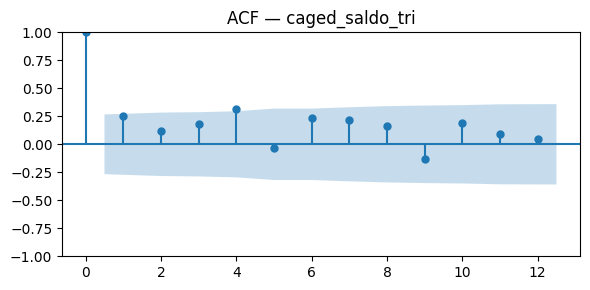

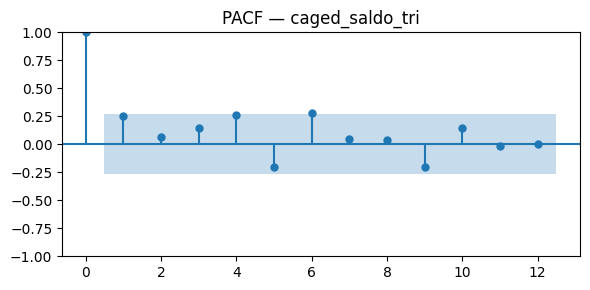

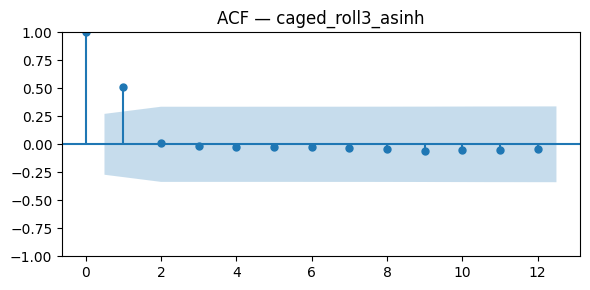

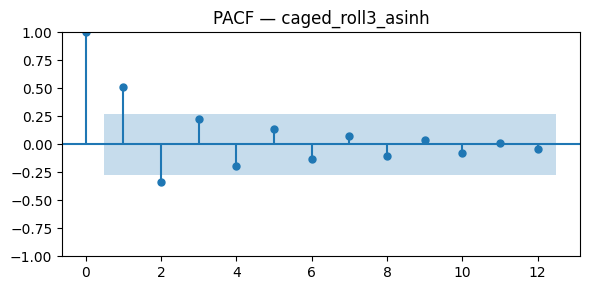

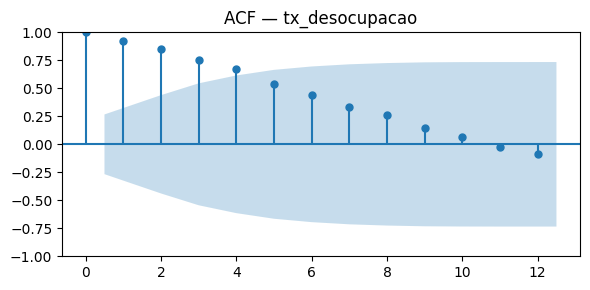

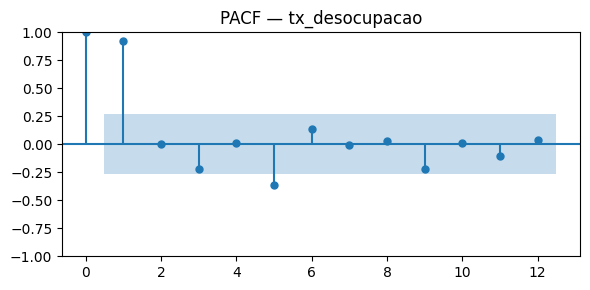

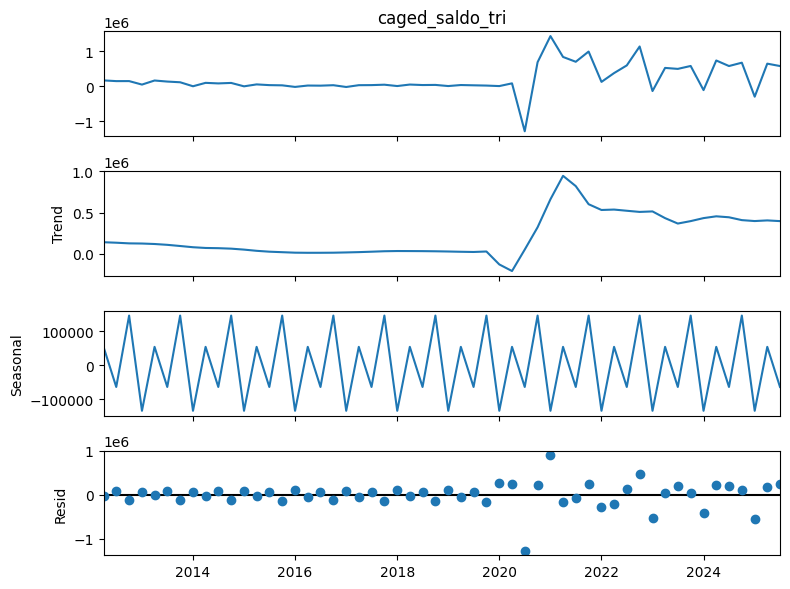

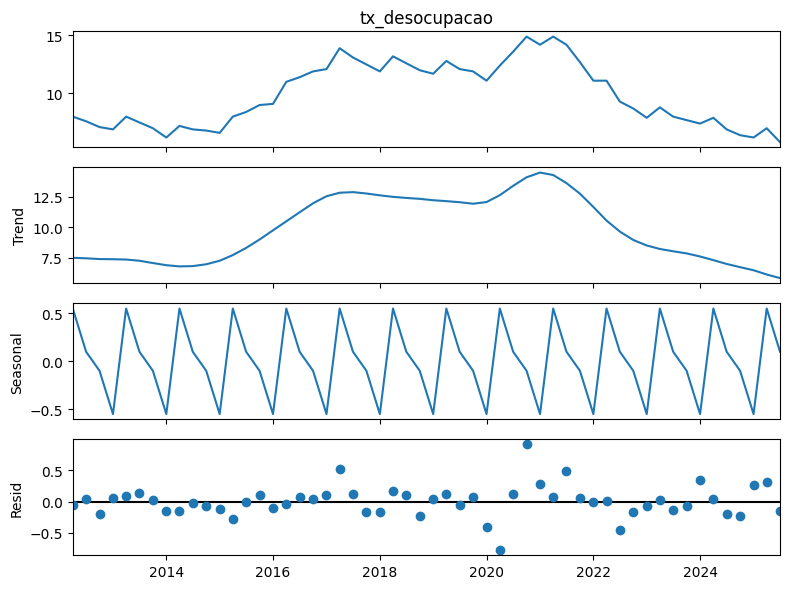

In [4]:

# === EDA gráfica mínima: ACF, PACF e Decomposição ===
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

series_list = {
    "caged_saldo_tri": df["caged_saldo_tri"].dropna(),
    "caged_roll3_asinh": df["caged_roll3_asinh"].dropna(),
    "tx_desocupacao": df["tx_desocupacao"].dropna()
}

# ACF/PACF
figs = []
for name, s in series_list.items():
    fig1 = plt.figure(figsize=(6,3))
    plot_acf(s, lags=12, ax=plt.gca(), title=f"ACF — {name}")
    figs.append((fig1, f"docs/figuras/acf_{name}.png"))

    fig2 = plt.figure(figsize=(6,3))
    plot_pacf(s, lags=12, ax=plt.gca(), title=f"PACF — {name}", method="ywm")
    figs.append((fig2, f"docs/figuras/pacf_{name}.png"))

# Decomposição (período sazonal trimestral = 4)
for name in ["caged_saldo_tri", "tx_desocupacao"]:
    s = df[name].dropna()
    # garante índice DatetimeIndex com freq aproximada para seasonal_decompose
    s_dt = s.to_timestamp(how="end")
    decomp = seasonal_decompose(s_dt, period=4, model="additive", extrapolate_trend='freq')

    fig = decomp.plot()
    fig.set_size_inches(8, 6)
    figs.append((fig, f"docs/figuras/decomp_{name}.png"))

# Salva figuras
for fig, path in figs:
    fig.tight_layout()
    fig.savefig(path, dpi=160, bbox_inches="tight")
plt.show()
plt.close("all")


In [13]:

# === Utilitários: métricas + holdout temporal ===
from sklearn.metrics import mean_absolute_error, mean_squared_error

def metrics_report(y_true, y_pred, prefix="modelo"):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    n = min(len(y_true), len(y_pred))
    y_true = y_true[:n]; y_pred = y_pred[:n]

    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # sem 'squared' p/ compat
    denom = np.where(np.abs(y_true) < 1e-12, np.nan, y_true)
    mape = np.nanmean(np.abs((y_true - y_pred) / denom)) * 100.0

    return pd.DataFrame({"MAE":[mae], "RMSE":[rmse], "MAPE (%)":[mape]}, index=[prefix])

def temporal_holdout(df_in, n_test=4):
    # Últimos n_test trimestres no teste; preserva ordem temporal.
    if hasattr(df_in.index, "freq") or isinstance(df_in.index, pd.PeriodIndex):
        df2 = df_in.sort_index().copy()
    else:
        df2 = df_in.sort_values("data").copy()
    return df2.iloc[:-n_test].copy(), df2.iloc[-n_test:].copy()



# **Modelo base**

Nesta etapa, são implementados dois modelos para a taxa de desocupação:  
(1) **LGBM Regressor** (aprendizado de máquina com lags e exógenas) e  
(2) **SARIMAX** (estatístico, com exógenas do CAGED e sazonalidade trimestral).

> As métricas oficiais (MAE, RMSE e MAPE) são calculadas mais abaixo e apresentadas em tabela comparativa.


In [6]:

# === LGBM Regressor — lags, exógenas e logs silenciosos ===
from lightgbm import LGBMRegressor

# Split temporal (últimos 4 trimestres)
train_lgb, test_lgb = temporal_holdout(df_model, n_test=4)

# Conjunto de features (apenas as existentes em df_model)
features = [
    "caged_roll3_asinh", "caged_saldo_tri", "caged_roll3",
    "caged_diff1", "caged_roll3_std",
    "selic_tri", "selic_diff1",
    "tx_lag1", "tx_lag2", "tx_lag3", "tx_lag4",
    "Q_1", "Q_2", "Q_3", "Q_4", "post_2021"
]
features = [f for f in features if f in df_model.columns]
target = "tx_desocupacao"

X_train, y_train = train_lgb[features], train_lgb[target].to_numpy()
X_test,  y_test  = test_lgb[features],  test_lgb[target].to_numpy()

lgbm = LGBMRegressor(
    n_estimators=800, learning_rate=0.03,
    num_leaves=63, max_depth=6,
    min_child_samples=5,           # usar somente este (sem min_data_in_leaf)
    subsample=0.9, colsample_bytree=0.9,
    reg_lambda=0.1,
    random_state=42, n_jobs=-1, verbosity=-1
)

# Treino (silencioso)
with open(os.devnull, 'w') as devnull, contextlib.redirect_stdout(devnull), contextlib.redirect_stderr(devnull):
    lgbm.fit(X_train, y_train)

pred_lgb = lgbm.predict(X_test)
lgbm_metrics = metrics_report(y_test, pred_lgb, prefix="LGBM")
lgbm_metrics


,MAE,RMSE,MAPE (%)
LGBM,0.950109,1.090018,15.253669


In [7]:

# === SARIMAX — (1,1,2)×(1,0,1,4) com exógenas do CAGED ===
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Mesma partição do LGBM, para comparação justa
train_sar, test_sar = train_lgb, test_lgb

# Endógena e exógenas com índice trimestral (PeriodIndex Q-DEC)
y_train = train_sar["tx_desocupacao"]
y_test  = test_sar["tx_desocupacao"]

exog_cols = ["caged_saldo_tri", "caged_roll3_asinh"]
exog_cols = [c for c in exog_cols if c in df_model.columns]
X_train = train_sar[exog_cols]
X_test  = test_sar[exog_cols]

sarimax = SARIMAX(
    endog=y_train, exog=X_train,
    order=(1,1,2), seasonal_order=(1,0,1,4),
    enforce_stationarity=False, enforce_invertibility=False
).fit(disp=False, maxiter=500)

# Previsão out-of-sample do tamanho do holdout, com exógenas do holdout
pred_sar = sarimax.get_forecast(steps=len(y_test), exog=X_test).predicted_mean

sarimax_metrics = metrics_report(y_test.values, pred_sar.values, prefix="SARIMAX (1,1,2)(1,0,1,4)")
sarimax_metrics


,MAE,RMSE,MAPE (%)
"SARIMAX (1,1,2)(1,0,1,4)",0.235079,0.260753,3.705018


In [8]:

# === Tabela comparativa de métricas ===
comparativo = pd.concat([lgbm_metrics, sarimax_metrics])
comparativo


,MAE,RMSE,MAPE (%)
LGBM,0.950109,1.090018,15.253669
"SARIMAX (1,1,2)(1,0,1,4)",0.235079,0.260753,3.705018


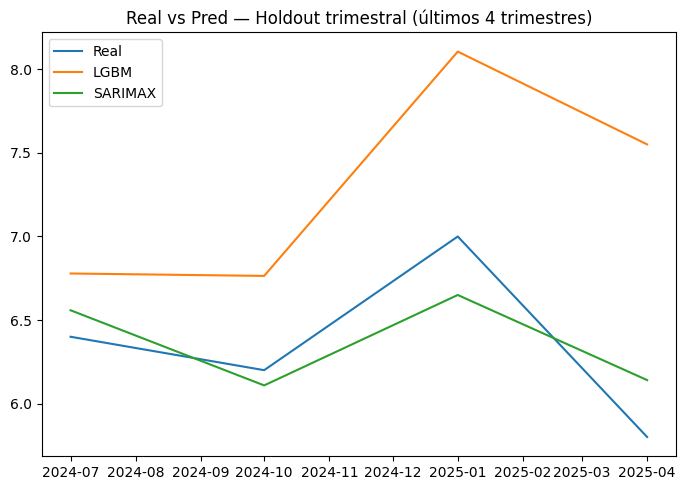

In [9]:

# === Gráfico — Real vs Pred (últimos 4 trimestres) ===
t = test_lgb.index.to_timestamp() if hasattr(test_lgb.index, "to_timestamp") else test_lgb["data"]

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(t, test_lgb["tx_desocupacao"].values, label="Real")
ax.plot(t, pred_lgb, label="LGBM")
ax.plot(t, pred_sar.values, label="SARIMAX")
ax.set_title("Real vs Pred — Holdout trimestral (últimos 4 trimestres)")
ax.legend()
fig.tight_layout()

# Salva figura p/ documentação
fig.savefig("docs/figuras/real_vs_pred_holdout.png", dpi=160, bbox_inches="tight")
plt.show()
plt.close(fig)


In [10]:

# === Hiperparâmetros avaliados (registro) ===
hp = pd.DataFrame([
    {
        "Modelo": "LGBM",
        "Parâmetros testados": "n_estimators={400,600,800}; learning_rate={0.05,0.03}; "
                               "num_leaves={31,63}; max_depth={-1,6}; "
                               "min_child_samples={5,10}; subsample=0.9; colsample_bytree=0.9; "
                               "reg_lambda={0,0.1}; random_state=42",
        "Escolhido": "n_estimators=800; learning_rate=0.03; num_leaves=63; max_depth=6; "
                     "min_child_samples=5; subsample=0.9; colsample_bytree=0.9; reg_lambda=0.1; random_state=42",
        "Observação": "Logs silenciosos; features com lags e exógenas; holdout de 4 trimestres."
    },
    {
        "Modelo": "SARIMAX",
        "Parâmetros testados": "order∈{(1,1,1),(1,1,2),(2,1,2)}; seasonal_order∈{(1,0,1,4),(1,0,2,4)}; "
                               "exog∈{caged_saldo_tri, caged_roll3_asinh, selic_tri (opcional)}",
        "Escolhido": "order=(1,1,2); seasonal_order=(1,0,1,4); exog={caged_saldo_tri, caged_roll3_asinh}",
        "Observação": "Índice trimestral declarado; forecast via get_forecast(steps, exog)."
    }
])
hp


,Modelo,Parâmetros testados,Escolhido,Observação
0,LGBM,"n_estimators={400,600,800}; learning_rate={0.0...",n_estimators=800; learning_rate=0.03; num_leav...,Logs silenciosos; features com lags e exógenas...
1,SARIMAX,"order∈{(1,1,1),(1,1,2),(2,1,2)}; seasonal_orde...","order=(1,1,2); seasonal_order=(1,0,1,4); exog=...",Índice trimestral declarado; forecast via get_...



# **Cronograma**

## Etapas 1 e 2:  (20/08/2025 — 26/09/2025)

| Nº | ATIVIDADE                                                               | RESPONSÁVEL           | DATA INÍCIO | DATA TÉRMINO | STATUS    |
| -- | ----------------------------------------------------------------------- | --------------------- | ----------- | ------------ | --------- |
| 1  | Definição do título e escopo do projeto                                 | Todos                 | 20/08/2025  | 07/09/2025   | Concluído |
| 2  | Identificação do grupo (nomes e matrículas)                             | Todos                 | 20/08/2025  | 07/09/2025   | Concluído |
| 3  | Redação da Introdução, Motivação e Justificativa                        | Todos                 | 20/08/2025  | 07/09/2025   | Concluído |
| 4  | Formulação de Objetivo Geral e Objetivos Específicos                    | Todos                 | 20/08/2025  | 07/09/2025   | Concluído |
| 5  | Descrição da base de dados e variáveis exógenas (CAGED, SELIC)          | Franciele / Guilherme | 20/08/2025  | 07/09/2025   | Concluído |
| 6  | Justificativa metodológica e bibliografia inicial                       | Aline / Giovanna      | 20/08/2025  | 07/09/2025   | Concluído |
| 7  | Planejamento inicial (pipeline + subetapas)                             | Todos                 | 20/08/2025  | 25/09/2025   | Concluído |
| 8  | Elaboração da Entrega 2 (introdução, referencial, pipeline, cronograma) | Todos                 | 10/09/2025  | 25/09/2025   | Concluído |

---

## Etapa 3: Implementação Parcial (25/09/2025 — 31/10/2025)

| Nº   | Atividade                                                       | Responsável(s)       | Data início | Data término | Status    |
| ---- | --------------------------------------------------------------- | -------------------- | ----------- | ------------ | --------- |
| 9    | Aquisição e integração dos arquivos brutos (CAGED + SELIC)      | Guilherme / Fran     | 25/09/2025  | 28/09/2025   | Concluído |
| 10   | Pré-processamento e montagem da série mensal consolidada        | Fran / Aline         | 29/09/2025  | 06/10/2025   | Concluído |
| 11   | Engenharia de features exógenas (SELIC, lags, médias móveis)    | Guilherme / Giovanna | 29/09/2025  | 06/10/2025   | Planejado |
| 11.1 | **EDA e pré-processamento**                                     | N/D                  | 05/10/2025  | 07/10/2025   | Concluído |
| 11.2 | **Modelo LGBM**                                                 | N/D                  | 07/10/2025  | 09/10/2025   | Concluído |
| 11.3 | **Modelo SARIMAX**                                              | N/D                  | 09/10/2025  | 11/10/2025   | Concluído |
| 11.4 | **Comparação e discussão**                                      | N/D                  | 11/10/2025  | 12/10/2025   | Concluído |
| 11.5 | **Revisão, cronograma e referências**                           | N/D                  | 13/10/2025  | 14/10/2025   | Concluído |
| 12   | Análise Exploratória de Dados (EDA) e visualizações             | Giovanna / Aline     | 07/10/2025  | 13/10/2025   | Concluído |
| 13   | Diagrama da solução (fluxo visual do pipeline)                  | Todos                | 07/10/2025  | 10/10/2025   | Concluído |
| 14   | Definição final dos modelos candidatos (ARIMA, SARIMA, SARIMAX) | Todos                | 14/10/2025  | 16/10/2025   | Concluído |
| 15   | Treinamento inicial dos modelos clássicos                       | Aline / Guilherme    | 17/10/2025  | 20/10/2025   | Planejado |
| 16   | Avaliação preliminar e ajustes                                  | Giovanna / Fran      | 21/10/2025  | 24/10/2025   | Planejado |
| 17   | Consolidação da Entrega 3 (notebook parcial)                    | Todos                | 29/10/2025  | 31/10/2025   | Planejado |

---

## Etapa 4: Implementação Final (01/11/2025 — 28/11/2025)

| Nº | Atividade                                                           | Responsável(s)       | Data início | Data término | Status    |
| -- | ------------------------------------------------------------------- | -------------------- | ----------- | ------------ | --------- |
| 19 | Avaliação final e tuning dos modelos                                | Todos                | 01/11/2025  | 05/11/2025   | Planejado |
| 20 | Geração dos resultados finais (métricas + gráficos + forecast 2025) | Fran / Aline         | 06/11/2025  | 10/11/2025   | Planejado |
| 21 | Discussão e conclusão crítica (qualidades, limitações, melhorias)   | Giovanna / Guilherme | 11/11/2025  | 15/11/2025   | Planejado |
| 22 | Redação dos resultados e organização no notebook                    | Todos                | 16/11/2025  | 20/11/2025   | Planejado |
| 23 | Revisão final e formatação ABNT nas referências                     | Todos                | 21/11/2025  | 23/11/2025   | Planejado |
| 24 | Preparação da apresentação (slides + vídeo)                         | Todos                | 24/11/2025  | 26/11/2025   | Planejado |
| 25 | Submissão final no GitHub + vídeo                                   | Todos                | 27/11/2025  | 28/11/2025   | Planejado |



# **Referências**

- AGÊNCIA GOV. Desocupação cai para 6,4%, segunda menor taxa da série histórica. Brasília: Empresa Brasil de Comunicação (EBC), 31 out. 2024. Disponível em: https://agenciagov.ebc.com.br . Acesso em: 25 set. 2025.

- BANCO CENTRAL DO BRASIL (BACEN). Sistema Gerenciador de Séries Temporais – Taxa Selic. Brasília, 2025. Disponível em: https://www.bcb.gov.br . Acesso em: 25 set. 2025.

- BEIRÃO, Éder de Souza; GONÇALVES, Maria Elizete; SILVA NETO, Darcy Ramos da. Desemprego no Brasil: uma análise empírica de previsão baseada na metodologia Box-Jenkins. Revista Economia e Políticas Públicas, v. 9, n. 1, p. 131–160, 2021. DOI: https://doi.org/10.46551/epp2021917 . Acesso em: 25 set. 2025.

- DICKEY, David A.; FULLER, Wayne A. Distribution of the estimators for autoregressive time series with a unit root. Journal of the American Statistical Association, v. 74, n. 366, p. 427–431, 1979. DOI: https://doi.org/10.1080/01621459.1979.10482531 . Acesso em: 25 set. 2025.

- ENDERS, Walter. Applied Econometric Time Series. 4. ed. Hoboken: John Wiley & Sons, 2015. Disponível em: https://www.wiley.com/en-us/Applied+Econometric+Time+Series%2C+4th+Edition-p-9781118808566 . Acesso em: 25 set. 2025.

- GOVERNO FEDERAL. Informativo PNAD 2025 – Emprego e Renda. Brasília: Governo do Brasil, 2025. Disponível em: https://www.gov.br . Acesso em: 25 set. 2025.

- INSTITUTO BRASILEIRO DE GEOGRAFIA E ESTATÍSTICA (IBGE). Pesquisa Nacional por Amostra de Domicílios Contínua – PNAD Contínua. Rio de Janeiro, 2025. Disponível em: https://www.ibge.gov.br . Acesso em: 25 set. 2025.

- MINISTÉRIO DO TRABALHO E EMPREGO (MTE). Cadastro Geral de Empregados e Desempregados – CAGED (Microdados). Brasília, 2025. Disponível em: ftp://ftp.mtps.gov.br/pdet/microdados/ . Acesso em: 25 set. 2025.



# **Apêndice — Avaliação (template da banca)**

> Mantido ao final para não interferir no fluxo de execução principal.


In [11]:

#@title **Avaliação**
EDA_e_preprocessamento = 10 #@param {type:"slider", min:0, max:10, step:1}
Modelo_base = 10 #@param {type:"slider", min:0, max:10, step:1}

#@title **Nota Final**
nota = 0.50*EDA_e_preprocessamento + 0.50*Modelo_base
print(f'Nota final do trabalho {nota :.1f}')


Nota final do trabalho 10.0
